1) Pre proccessing:
    1.1 Load the model and data set 10-50 classes traffic
    1.2 From Image into 16*16 segments with the corresponding label according to the data set
    1.3 mask conv

2) Train the semantic decoder:
    2.1  Load the model BIER 
    _____________________________
    2.2  Train loop:
                    input: 16*16 segments
                    output: class for each segment
    -  Loss function: Cross entropy 
    -  Optimizer: Adam
    -  Epochs: 100
    -  Batch size: 32
    -  Learning rate: 0.001
    -  Save the model

3) Final model:
    3.1 Build our model: add the semantic decoder(the one we traind with the pre process as part of the model) to the model BIER(clean non trained)  in one of the layers
    3.2 Train loop:
                    WE will train our model and the clasic BIER model and compare the results


# Part 0

### TODO:
* I Want to download the masks  file into masks variable but It is not working.

In [2]:
import data_set_utils as data_utils
import numpy as np
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import sys
import torch
import cv2

In [3]:
import torch

print(f"CUDA available: {torch.cuda.is_available()}")


CUDA available: False


/home/benjaminc/miniconda3/envs/vitenv/lib/python3.10/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11080). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


### Setup the dataset
- First we will load the dataset as a list of paths pairs (imagePath, masksPath) where:
    * masksPath is the path to the masks file, and the masks is the result of the segmentation of the image in imagePath.

### Load Segment everything model

In [4]:
import os
import torch
import sys

# Ensure you can import from the parent directory
sys.path.append("..")

# Get current directory until the SAT directory
cwd = os.getcwd()

sam_checkpoint = os.path.join(cwd, "segment-anything", "sam_vit_h_4b8939.pth")

model_type = "vit_h"

# Set CUDA_VISIBLE_DEVICES to specify GPU 2
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# Ensure CUDA is available and set the device to cuda:0 (which should map to the real GPU 2)
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

# Print the current device being used
print(f"Using device: {device}")

# Load the model
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)





Using device: cpu


# Part 1

## Segmented image to sequence of masks

We will use the model to segment the image and then we will convert the segmented image to a sequence of mini images each of them contains a mask bounding box and all the mini images will be in same fix size.


#### Example
Let's start by example of creating from image the corresponding masks and mini_images for each mask

In [5]:
image = cv2.imread("/home/benjaminc/project_transformers/mainSat/segment-anything/dataset_seg_ev/plage.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [6]:
import image2segVec as image2Vec

masks = image2Vec.image2segVec(image=image,size=(256,256))


In [ ]:
#print box for example
print(masks[2]['bbox'])


[1063, 557, 190, 85]


In [ ]:
#import convolve2d
from scipy.signal import convolve, convolve2d



#==================================================================================================
#                                     Create Mini Images
#==================================================================================================
# Expand the mask to be a square that his side is the longest side of the mask(the smallest square that contains the mask)
def mini_image_bbox_to_square(bbox):
    if bbox[2] > bbox[3]:
        bbox[1] -= (bbox[2] - bbox[3]) // 2
        bbox[3] = bbox[2]
    else:
        bbox[0] -= (bbox[3] - bbox[2]) // 2
        bbox[2] = bbox[3]
    return bbox


    


# Resize the clean cropped image to maintain aspect ratio
def resize_image(image, size):
    # image n*n*3 to size*size*3
    new_height, new_width = size
    height, width = image.shape[:2]
    if height > width:
        new_height = size[0]
        new_width = int(width * new_height / height)
    else:
        new_width = size[1]
        new_height = int(height * new_width / width)
    resized_image = cv2.resize(image, (new_width, new_height))
    return resized_image
    

def apply_convolution_with_scipy(image, mask, kernel_size):
    kernel = np.ones((kernel_size, kernel_size), dtype=float) / (kernel_size ** 2)
    result = np.zeros_like(image)
    for c in range(image.shape[2]):
        result[:, :, c] = convolve2d(image[:, :, c] * mask, kernel, mode='same', boundary='fill', fillvalue=0)
    return result



def create_mini_imagess(image, masks, size=(600, 600),print_resualts = False):
    mini_images_clean = []
    mini_images_original = []   
    original_masks = masks
    for mask in masks:
        # find the center of the mask and devide bythe width of the image to get the position of the mask in the image
        center = mask['bbox'][0] + mask['bbox'][2] // 2, mask['bbox'][1] + mask['bbox'][3] // 2
        center = center[0] / image.shape[1], center[1] / image.shape[0]
        

        # Extract the bounding box and the mask
        bbox = mini_image_bbox_to_square(mask['bbox'])
        #check if the mask is in the image and a box
        if bbox[0] < 0 or bbox[1] < 0 or bbox[2] < 0 or bbox[3] < 0:
            continue
        if bbox[0] + bbox[2] > image.shape[1] or bbox[1] + bbox[3] > image.shape[0]:
            continue

        # check if the mask is a square if not  set the mask to be a the smallest square that contains the mask and the image
        if bbox[2] != bbox[3]:
            bbox = mini_image_bbox_to_square(bbox)
            
        segmentation_mask = mask['segmentation']

        # Crop the image and mask to the square bounding box(the smallest square that contains the mask)
        cropped_image = image[bbox[1]:bbox[1] + bbox[3], bbox[0]:bbox[0] + bbox[2]]
        cropped_mask = segmentation_mask[bbox[1]:bbox[1] + bbox[3], bbox[0]:bbox[0] + bbox[2]]


      
        # Calculate the mean color within the mask and find the farthest color
        #masked_pixels = cropped_image[cropped_mask]
        #mean_color, farthest_color = get_mean_and_farthest_color(cropped_image, cropped_mask)

        # outside of the mask *0.2 inside original color
        clean_cropped_image = np.zeros_like(cropped_image)
        clean_cropped_image[cropped_mask] = cropped_image[cropped_mask]
        clean_cropped_image[~cropped_mask] = cropped_image[~cropped_mask] * 0.5

        


        if clean_cropped_image.size == 0 or clean_cropped_image.shape[0] == 0 or clean_cropped_image.shape[1] == 0:
            #print("Invalid image dimensions for resizing. Skipping this mask.")
            continue  # Skip this mask

        if cropped_image.size == 0 or cropped_image.shape[0] == 0 or cropped_image.shape[1] == 0:
            #print("Invalid image dimensions for resizing. Skipping this mask.")
            continue

        # Resize the clean cropped image to maintain aspect ratio
        clean_cropped_image = resize_image(clean_cropped_image, size)
        cropped_image = resize_image(cropped_image, size)



        # Place the resized image in the center of the canvas
   
        """
        #we have binary mask size of image 1 where is the segment ans 0 where not we want to make positional encoding by take kernel path_sizepatch_sizeimage[wher ethe colors] and multiple it like conv over the mask (first make it like image from binary ) so the return is image//number of patch like mini image
        """
        #
        # multiple the ccentroids of the mask by the size of the image to get the position of the mask in the image
       # center = center[0] * size[0], center[1] * size[1]+size[1]//2
        # clean_cropped_image =  clean_cropped_image + center[0]//size[0] add with clip

       # clean_cropped_image = np.clip(clean_cropped_image + center[0]//size[0],0,255)



        mini_images_original.append(cropped_image)

        mini_images_clean.append(clean_cropped_image)



    if print_resualts:
        fig, ax = plt.subplots(1, 2, figsize=(10, 10))
        ax[0].imshow(image)
        ax[0].axis('off')
        ax[0].set_title('Original Image')
        ax[1].imshow(image)
        if original_masks is not None:
            show_anns(original_masks)
        ax[1].axis('off')
        ax[1].set_title('Image with Masks')
        plt.show()


        
    return mini_images_clean, mini_images_original


#--------------------------------------------------------------------------------------------------
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)
mini_images_clean, mini_images_original= create_mini_imagess(image, masks,size=(40,40))
print(masks)



NameError: name 'image' is not defined

In [ ]:
"""
data_utils.show_image_and_mask(image, masks)
image2Vec.print_grid(mini_images_clean,n_cols=10)
image2Vec.print_grid(mini_images_original,n_cols=10)
# print number of mini masks
print("Number of mini masks: ", len(mini_images_clean))

#plot one of the mini imag
import matplotlib.pyplot as plt
plt.imshow(mini_images_clean[4])


"""

'\ndata_utils.show_image_and_mask(image, masks)\nimage2Vec.print_grid(mini_images_clean,n_cols=10)\nimage2Vec.print_grid(mini_images_original,n_cols=10)\n# print number of mini masks\nprint("Number of mini masks: ", len(mini_images_clean))\n\n#plot one of the mini imag\nimport matplotlib.pyplot as plt\nplt.imshow(mini_images_clean[4])\n\n\n'

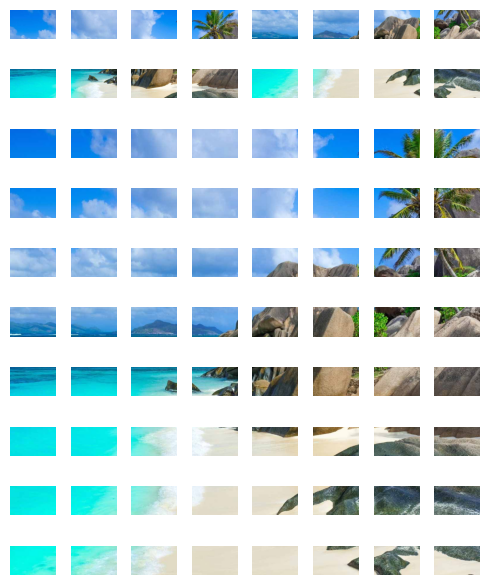

Number of patches:  80


In [ ]:

# patch the image into 8x8 patches according the size of the image
def patches_image(image, patch_num=8):
    #fic the size of the image to be a multiple of patch_num
    height, width = image.shape[:2]
    height = height - height % patch_num
    width = width - width % patch_num
    image = image[:height, :width]
    #split the image to patch_num*patch_num patches
    patch_height = height // patch_num
    patch_width = width // patch_num
    patches = []
    for i in range(patch_num):
        for j in range(patch_num):
            patch = image[i * patch_height:(i + 1) * patch_height, j * patch_width:(j + 1) * patch_width]
            patches.append(patch)

    return patches

#plot the patches of the image
patches4 = patches_image(image, patch_num=4)
patches8 = patches_image(image, patch_num=8)
patches = patches4 + patches8
image2Vec.print_grid(patches, n_cols=8)
print("Number of patches: ", len(patches))


Number of mini masks:  135


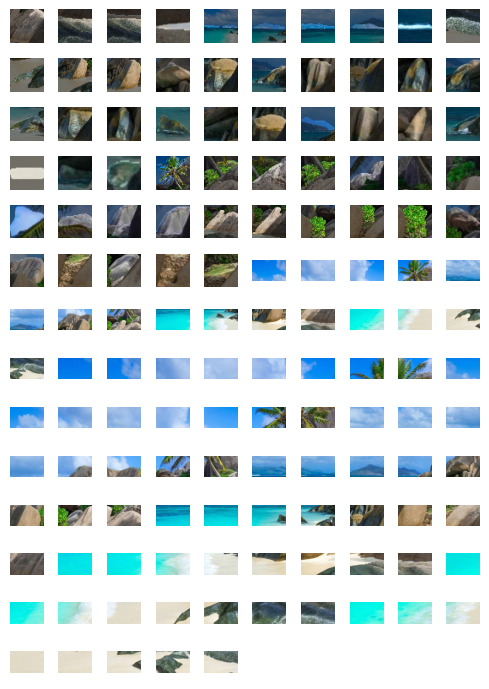

In [ ]:
#add the patches into the clean mini images

mini_images_clean.extend(patches)
print("Number of mini masks: ", len(mini_images_clean))
image2Vec.print_grid(mini_images_clean,n_cols=10)

# 



In [ ]:
#add mini images to the original mini images until 256 according the order
while len(mini_images_clean) < 256:
    mini_images_clean.extend(mini_images_clean)
    mini_images_original.extend(mini_images_original)
#cut the mini images to be 256
mini_images_clean = mini_images_clean[:256]




Grid size: 16x16
Mini image size: 40x40
Final image size: 640x640
The Length of the mini images:  614


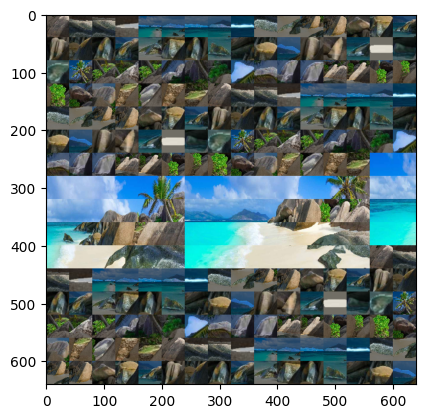

In [ ]:
#create grid image of the mini images,actual image


def create_square_grid_image(mini_images,image,print_en=False):

    #double the mini images to be able to fill the grid, mini_images_Double = mini_images + mini_images
    mini_images_runner = []

    # Calculate the dimensions of the grid
    l = len(mini_images)
    n = 16 # The size of the grid (n x n)
    
    if l == 0:
        return None  # Return None if the list of images is empty

    # Clean the mini images that have the wrong shape
    mini_images_clean = [mini_images[i] for i in range(l) if mini_images[i].shape[0] == mini_images[i].shape[1]]
    mini_images = mini_images_clean

    channels = mini_images_clean[0].shape[2] if len(mini_images_clean[0].shape) == 3 else 1
    mini_image_size = mini_images_clean[0].shape[0]

    # Create an empty image for the final image the image is n*mini_image_size x n*mini_image_size
    img = np.zeros((n * mini_image_size, n * mini_image_size, channels), dtype=np.uint8)

    if print_en:
        # Print the grid
        print(f"Grid size: {n}x{n}")
        print(f"Mini image size: {mini_image_size}x{mini_image_size}")
        print(f"Final image size: {n * mini_image_size}x{n * mini_image_size}")

    # Fill the grid
    # Make  set of mini images twice
    mini_image_runner = []

    mini_image_runner += mini_images_clean + mini_images_clean  + mini_images_clean + mini_images_clean
    # Patch the original image 8 and 4
    image_patches = patches_image(image)   
    #resize to quares: image_patches to miniimsge size
    mini_image_size = mini_images_clean[0].shape[0]
    image_patches = [cv2.resize(patch, (mini_image_size, mini_image_size)) for patch in image_patches]
     
    mini_images_clean = mini_images_clean + image_patches  + mini_image_runner  

    for i in range(n):
        for j in range(n):
            idx = i * n + j
            # Check if the mini image have the same shape as the mini_image_size
            if mini_images_clean[idx].shape[0] != mini_image_size or mini_images_clean[idx].shape[1] != mini_image_size:
                print(f"Mini image {idx} has the wrong shape")
            else:
                img[i * mini_image_size:(i + 1) * mini_image_size, j * mini_image_size:(j + 1) * mini_image_size] = mini_images_clean[idx]

    print("The Length of the mini images: ", len(mini_images_clean))
    return img

import matplotlib.pyplot as plt
# Create the grid image
grid_image = create_square_grid_image(mini_images_clean,image,print_en=True)
plt.imshow(grid_image)


In [ ]:
#now we will do function that ger patch_num and image and create grid with the seg and the patches 
def final_pre_image(image, patch_num=16):
    len_of_mini_images = patch_num*patch_num
    #get masks from the image
    masks = image2Vec.image2segVec(image=image,size=(256,256))
    #get the mini images clean and original
    mini_images_clean, mini_images_original = create_mini_imagess(image, masks,size=(40,40))
    #create the patches
    patches4 = patches_image(image, patch_num=4)
    patches8 = patches_image(image, patch_num=8)
    patches = patches4 + patches8
    #add the patches to the mini images
    mini_images_clean.extend(patches)
    #add the mini images to the original mini images until 256 according the order
    while len(mini_images_clean) < patch_num*patch_num:
        mini_images_clean.extend(mini_images_clean)
        mini_images_original.extend(mini_images_original)

    #cut the mini images to be 256
    mini_images_clean = mini_images_clean[:patch_num*patch_num]

    #create the grid image 
    grid_image = create_square_grid_image(mini_images_clean,image,print_en=True)
    # resize into 512
    grid_image = cv2.resize(grid_image, (512, 512))
    return grid_image

image = cv2.imread("/home/benjaminc/project_transformers/mainSat/segment-anything/dataset_seg_ev/plage.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

grid_image = final_pre_image(image, patch_num=16)

    




    

    

Grid size: 16x16
Mini image size: 40x40
Final image size: 640x640
The Length of the mini images:  614


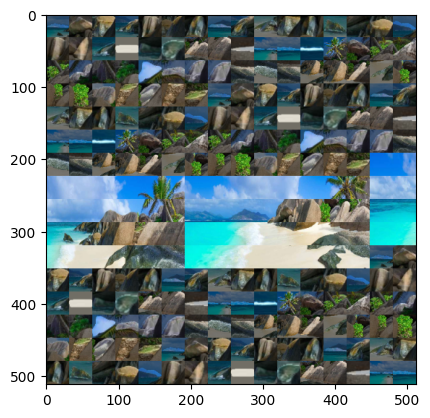

In [ ]:
plt.imshow(grid_image)


In [ ]:
model_checkpoint = "nvidia/mit-b0"  # pre-trained model from which to fine-tune
batch_size = 4  # batch size for training and evaluation

In [ ]:
!pip -q install datasets transformers evaluate

!git lfs install
!git config --global credential.helper store

git: 'lfs' is not a git command. See 'git --help'.

The most similar command is
	log


In [ ]:
from transformers.utils import send_example_telemetry

send_example_telemetry("semantic_segmentation_notebook", framework="pytorch")
from datasets import load_dataset

hf_dataset_identifier = "segments/sidewalk-semantic"
ds = load_dataset(hf_dataset_identifier)


/home/benjaminc/miniconda3/envs/vitenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 1000
    })
})

In [ ]:


import evaluate

metric = evaluate.load("mean_iou")
from huggingface_hub import hf_hub_download
import json

filename = "id2label.json"
id2label = json.load(
    open(hf_hub_download(hf_dataset_identifier, filename, repo_type="dataset"), "r")
)
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

num_labels = len(id2label)
num_labels, list(label2id.keys())
num_labels, list(label2id.keys())

(35,
 ['unlabeled',
  'flat-road',
  'flat-sidewalk',
  'flat-crosswalk',
  'flat-cyclinglane',
  'flat-parkingdriveway',
  'flat-railtrack',
  'flat-curb',
  'human-person',
  'human-rider',
  'vehicle-car',
  'vehicle-truck',
  'vehicle-bus',
  'vehicle-tramtrain',
  'vehicle-motorcycle',
  'vehicle-bicycle',
  'vehicle-caravan',
  'vehicle-cartrailer',
  'construction-building',
  'construction-door',
  'construction-wall',
  'construction-fenceguardrail',
  'construction-bridge',
  'construction-tunnel',
  'construction-stairs',
  'object-pole',
  'object-trafficsign',
  'object-trafficlight',
  'nature-vegetation',
  'nature-terrain',
  'sky',
  'void-ground',
  'void-dynamic',
  'void-static',
  'void-unclear'])

In [ ]:
ds = ds.shuffle(seed=1)
ds = ds["train"].train_test_split(test_size=0.995)
train_ds = ds["train"]
test_ds = ds["test"]
#example 


In [ ]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)

feature_extractor

/home/benjaminc/miniconda3/envs/vitenv/lib/python3.10/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/home/benjaminc/miniconda3/envs/vitenv/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py:103: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


SegformerFeatureExtractor {
  "_valid_processor_keys": [
    "images",
    "segmentation_maps",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "do_reduce_labels",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": true,
  "do_reduce_labels": false,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "SegformerFeatureExtractor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 512,
    "width": 512
  }
}

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
from datasets import load_dataset
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation, TrainingArguments, Trainer
import torch
from torch import nn
import evaluate
import json
from huggingface_hub import hf_hub_download
from torchvision.transforms import ColorJitter

# Function to apply segTokenaizer and revert format
def segTokenaizer(image, patch_num=16):
    len_of_mini_images = patch_num * patch_num
    masks = image2Vec.image2segVec(image=image, size=(256, 256))
    mini_images_clean, mini_images_original = create_mini_imagess(image, masks, size=(40, 40))
    patches4 = patches_image(image, patch_num=4)
    patches8 = patches_image(image, patch_num=8)
    patches = patches4 + patches8
    mini_images_clean.extend(patches)
    while len(mini_images_clean) < patch_num * patch_num:
        mini_images_clean.extend(mini_images_clean)
        mini_images_original.extend(mini_images_original)
    mini_images_clean = mini_images_clean[:patch_num * patch_num]
    grid_image = create_square_grid_image(mini_images_clean, image, print_en=True)
    grid_image = cv2.resize(grid_image, (512, 512))
    return grid_image

# Load and preprocess dataset
hf_dataset_identifier = "segments/sidewalk-semantic"
ds = load_dataset(hf_dataset_identifier)
ds = ds.shuffle(seed=1)
ds = ds["train"].train_test_split(test_size=0.2)
train_ds = ds["train"]
test_ds = ds["test"]

# Print dataset lengths
print(f"Number of training examples: {len(train_ds)}")
print(f"Number of testing examples: {len(test_ds)}")

# Process a certain percentage of the dataset
percentage_to_process = 100  # Adjust this percentage as needed

# Load id2label mapping
filename = "id2label.json"
id2label = json.load(open(hf_hub_download(repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset"), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

# Preprocess and save all images in a single directory
def preprocess_and_save(ds, split, percentage):
    dir_path = f"/home/benjaminc/project_transformers/mainSat/tokenizer_data/{split}"
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    
    total_images = int(len(ds) * (percentage / 100))

    j =600
    for i in range(total_images):
        j+=1
        if j > len(ds):
            break
        example = ds[j]
        image_path = os.path.join(dir_path, f"pixel_values_{j}.npy")

        if not os.path.exists(image_path):
            # Convert image to RGB format
            image_cv2 = cv2.cvtColor(np.array(example["pixel_values"]), cv2.COLOR_BGR2RGB)
            # Apply final_pre_image
            processed_image_pil = segTokenaizer(image_cv2)
            # Convert back to BGR format
            processed_image_cv2 = cv2.cvtColor(np.array(processed_image_pil), cv2.COLOR_RGB2BGR)
            # Save the processed image to disk
            np.save(image_path, processed_image_cv2)
        else:
            # Load the processed image from disk
            processed_image_cv2 = np.load(image_path)

        # Update the example with the processed image
        ds[j]["pixel_values"] = processed_image_cv2

        if j % 10 == 0:
            print(f"Processed {j} images for {split} ({(j/total_images)*100:.2f}%)")

preprocess_and_save(train_ds, "train", percentage_to_process)
preprocess_and_save(test_ds, "test", percentage_to_process)

# Ensure transformations are removed before saving the dataset
train_ds.set_transform(None)
test_ds.set_transform(None)

# Save the dataset
train_ds.save_to_disk("/home/benjaminc/project_transformers/mainSat/train_dataset")
test_ds.save_to_disk("/home/benjaminc/project_transformers/mainSat/test_dataset")

# Set up the processor and transformations
processor = SegformerImageProcessor()
jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.002)  # Reduced hue to avoid overflow

def train_transforms(example_batch):
    images = [jitter(x) for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = processor(images, labels)
    return inputs

def val_transforms(example_batch):
    images = [x for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = processor(images, labels)
    return inputs

# Set transforms
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

# Initialize the model
pretrained_model_name = "nvidia/mit-b0"
model = SegformerForSemanticSegmentation.from_pretrained(
    pretrained_model_name,
    id2label=id2label,
    label2id=label2id
)

# Training arguments
epochs = 50
lr = 0.00006
batch_size = 64

hub_model_id = "segformer-b0-finetuned-segments-sidewalk-oct-22"

training_args = TrainingArguments(
    "segformer-b0-finetuned-segments-sidewalk-outputs",
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    push_to_hub=True,
    hub_model_id=hub_model_id,
    hub_strategy="end",
)

# Evaluation metric
metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        # Scale the logits to the size of the label
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()
        metrics = metric.compute(
            predictions=pred_labels,
            references=labels,
            num_labels=len(id2label),
            ignore_index=0,
            reduce_labels=processor.do_reduce_labels,
        )

        # Add per category metrics as individual key-value pairs
        per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
        per_category_iou = metrics.pop("per_category_iou").tolist()

        metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
        metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

        return metrics

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

# Start training
trainer.train()


Number of training examples: 800
Number of testing examples: 200
Processed 610 images for train (76.25%)
Processed 620 images for train (77.50%)
Processed 630 images for train (78.75%)
Processed 640 images for train (80.00%)


Grid size: 16x16
Mini image size: 40x40
Final image size: 640x640
The Length of the mini images:  394
Grid size: 16x16
Mini image size: 40x40
Final image size: 640x640
The Length of the mini images:  944
Processed 650 images for train (81.25%)
Grid size: 16x16
Mini image size: 40x40
Final image size: 640x640
The Length of the mini images:  944
Grid size: 16x16
Mini image size: 40x40
Final image size: 640x640
The Length of the mini images:  944
Grid size: 16x16
Mini image size: 40x40
Final image size: 640x640
The Length of the mini images:  864
Grid size: 16x16
Mini image size: 40x40
Final image size: 640x640
The Length of the mini images:  784
Grid size: 16x16
Mini image size: 40x40
Final image size: 640x640
The Length of the mini images:  824
Grid size: 16x16
Mini image size: 40x40
Final image size: 640x640
The Length of the mini images:  664
Grid size: 16x16
Mini image size: 40x40
Final image size: 640x640
The Length of the mini images:  944
Grid size: 16x16
Mini image size: 40x40
Fi

In [ ]:
from torchvision.transforms import ColorJitter
from transformers import SegformerFeatureExtractor
from torchvision.transforms.functional import to_tensor, to_pil_image
from PIL import Image
import torch
import numpy as np
"""
feature_extractor = SegformerFeatureExtractor()
jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)

def apply_jitter_and_clip(image):
    # Apply jitter
    image = jitter(image)
    # Convert image to tensor to use torch.clamp
    image = to_tensor(image)
    # Ensure that values are normalized to [0, 1] range
    image = torch.clamp(image, 0, 1)
    # Convert back to PIL Image
    image = to_pil_image(image)
    return image

def final_pre_image(image, patch_num):
    # Assuming this function is implemented correctly elsewhere in your code
    # This function should handle the image preprocessing logic
    pass

# Access images correctly from the dataset
final_val = [final_pre_image(apple, patch_num=16) for apple in test_ds["pixel_values"]]
final_train = [final_pre_image(apple, patch_num=16) for apple in train_ds["pixel_values"]]

def val_transforms_tokens_segments(example_batch):
    images = [x for x in final_val]
    labels = [x for x in example_batch['label']]
    inputs = feature_extractor(images, labels)
    return inputs

def train_transforms_tokens_segments(example_batch):
    images = [apply_jitter_and_clip(x['image']) for x in final_train]
    labels = [x for x in example_batch['label']]
    inputs = feature_extractor(images, labels)
    return inputs 

# Set transforms
train_ds.set_transform(train_transforms_tokens_segments)
test_ds.set_transform(val_transforms_tokens_segments)
"""


'\nfeature_extractor = SegformerFeatureExtractor()\njitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)\n\ndef apply_jitter_and_clip(image):\n    # Apply jitter\n    image = jitter(image)\n    # Convert image to tensor to use torch.clamp\n    image = to_tensor(image)\n    # Ensure that values are normalized to [0, 1] range\n    image = torch.clamp(image, 0, 1)\n    # Convert back to PIL Image\n    image = to_pil_image(image)\n    return image\n\ndef final_pre_image(image, patch_num):\n    # Assuming this function is implemented correctly elsewhere in your code\n    # This function should handle the image preprocessing logic\n    pass\n\n# Access images correctly from the dataset\nfinal_val = [final_pre_image(apple, patch_num=16) for apple in test_ds["pixel_values"]]\nfinal_train = [final_pre_image(apple, patch_num=16) for apple in train_ds["pixel_values"]]\n\ndef val_transforms_tokens_segments(example_batch):\n    images = [x for x in final_val]\n    labels =

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image

print(len(ds["train"]))

for i in range(len(ds["train"])):
    example = ds["train"][i]
    dir_path = f"/home/benjaminc/project_transformers/mainSat/dataToken{i}"

    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        # Convert image to RGB format
        image_cv2 = cv2.cvtColor(np.array(example["pixel_values"]), cv2.COLOR_BGR2RGB)
        # Apply final_pre_image
        processed_image_pil = final_pre_image(image_cv2)
        # Convert back to BGR format
        processed_image_cv2 = cv2.cvtColor(np.array(processed_image_pil), cv2.COLOR_RGB2BGR)
        # Save the processed image to disk
        np.save(os.path.join(dir_path, "pixel_values.npy"), processed_image_cv2)
    else:
        # Load the processed image from disk
        processed_image_cv2 = np.load(os.path.join(dir_path, "pixel_values.npy"))

    # Update the example with the processed image
    example["pixel_values"] = processed_image_cv2

    if i % 10 == 0:
        print(f"Processed {i} images")

# Ensure transformations are removed before saving the dataset
ds["train"].set_transform(None)
ds["test"].set_transform(None)

# Save the dataset
ds["train"].save_to_disk("/home/benjaminc/project_transformers/mainSat/train_dataset")
ds["test"].save_to_disk("/home/benjaminc/project_transformers/mainSat/test_dataset")



5
Processed 0 images


Saving the dataset (1/1 shards): 100%|██████████| 995/995 [00:01<00:00, 749.31 examples/s] 


In [ ]:
"""
from torchvision.transforms import ColorJitter
from transformers import SegformerFeatureExtractor

feature_extractor = SegformerFeatureExtractor()
jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)

def train_transforms(example_batch):
    images = [jitter(x) for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = feature_extractor(images, labels)
    return inputs


def val_transforms(example_batch):
    images = [x for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = feature_extractor(images, labels)
    return inputs


# Set transforms
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

"""

"\nfrom torchvision.transforms import ColorJitter\nfrom transformers import SegformerFeatureExtractor\n\nfeature_extractor = SegformerFeatureExtractor()\njitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)\n\ndef train_transforms(example_batch):\n    images = [jitter(x) for x in example_batch['pixel_values']]\n    labels = [x for x in example_batch['label']]\n    inputs = feature_extractor(images, labels)\n    return inputs\n\n\ndef val_transforms(example_batch):\n    images = [x for x in example_batch['pixel_values']]\n    labels = [x for x in example_batch['label']]\n    inputs = feature_extractor(images, labels)\n    return inputs\n\n\n# Set transforms\ntrain_ds.set_transform(train_transforms)\ntest_ds.set_transform(val_transforms)\n\n"

In [ ]:
from torchvision.transforms import ColorJitter
from transformers import SegformerFeatureExtractor

feature_extractor = SegformerFeatureExtractor()
jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)

def train_transforms(example_batch):
    images = [jitter(x) for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = feature_extractor(images, labels)
    return inputs


def val_transforms(example_batch):
    images = [x for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = feature_extractor(images, labels)
    return inputs


# Set transforms
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

In [ ]:
from transformers import SegformerForSemanticSegmentation


model = SegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,  # Will ensure the segmentation specific components are reinitialized.
)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

epochs = 50
lr = 0.00006
batch_size = 2

hub_model_id = "segformer-b0-finetuned-segments-sidewalk-2"

training_args = TrainingArguments(
    "segformer-b0-finetuned-segments-sidewalk-outputs",
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    push_to_hub=True,
    hub_model_id=hub_model_id,
    hub_strategy="end",
)



In [ ]:
import torch
from torch import nn
import evaluate

metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
  with torch.no_grad():
    logits, labels = eval_pred
    logits_tensor = torch.from_numpy(logits)
    # scale the logits to the size of the label
    logits_tensor = nn.functional.interpolate(
        logits_tensor,
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=False,
    ).argmax(dim=1)

    pred_labels = logits_tensor.detach().cpu().numpy()
    # currently using _compute instead of compute
    # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
    metrics = metric._compute(
            predictions=pred_labels,
            references=labels,
            num_labels=len(id2label),
            ignore_index=0,
            reduce_labels=feature_extractor.do_reduce_labels,
        )

    # add per category metrics as individual key-value pairs
    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

    return metrics



In [ ]:
from transformers import Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=feature_extractor,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

In [1]:
import os
import cv2
import numpy as np
from PIL import Image
from datasets import load_dataset
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation, TrainingArguments, Trainer
import torch
from torch import nn
import evaluate
import json
from huggingface_hub import hf_hub_download
from torchvision.transforms import ColorJitter

# Load and preprocess dataset
hf_dataset_identifier = "segments/sidewalk-semantic"
ds = load_dataset(hf_dataset_identifier)
ds = ds.shuffle(seed=1)
ds = ds["train"].train_test_split(test_size=0.2)
train_ds = ds["train"]
test_ds = ds["test"]

# Load id2label mapping
filename = "id2label.json"
id2label = json.load(open(hf_hub_download(repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset"), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

# Function to apply final_pre_image and revert format
def final_pre_image(image):
    # Implement your final_pre_image processing here
    return image

def preprocess_and_save(ds, split, num_images):
    for i in range(num_images):
        example = ds[i]
        dir_path = f"/home/benjaminc/project_transformers/mainSat/tokenizer_data/train/pixel_values_0_{i}.npy"

        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
            # Convert image to RGB format
            image_cv2 = cv2.cvtColor(np.array(example["pixel_values"]), cv2.COLOR_BGR2RGB)
            # Apply final_pre_image
            processed_image_pil = final_pre_image(image_cv2)
            # Convert back to BGR format
            processed_image_cv2 = cv2.cvtColor(np.array(processed_image_pil), cv2.COLOR_RGB2BGR)
            # Save the processed image to disk
            np.save(os.path.join(dir_path, "pixel_values.npy"), processed_image_cv2)
        else:
            # Load the processed image from disk
            processed_image_cv2 = np.load(os.path.join(dir_path, "pixel_values.npy"))

        # Update the example with the processed image
        ds[i]["pixel_values"] = processed_image_cv2

        if i % 10 == 0:
            print(f"Processed {i} images for {split}")

preprocess_and_save(train_ds, "train", 3)
preprocess_and_save(test_ds, "test", 3)

# Ensure transformations are removed before saving the dataset
train_ds.set_transform(None)
test_ds.set_transform(None)

# Save the dataset
train_ds.save_to_disk("/home/benjaminc/project_transformers/mainSat/train_dataset")
test_ds.save_to_disk("/home/benjaminc/project_transformers/mainSat/test_dataset")

# Set up the processor and transformations
processor = SegformerImageProcessor()
jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.002)  # Reduced hue to avoid overflow

def train_transforms(example_batch):
    images = [jitter(x) for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = processor(images, labels)
    return inputs

def val_transforms(example_batch):
    images = [x for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = processor(images, labels)
    return inputs

# Set transforms
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

# Initialize the model
pretrained_model_name = "nvidia/mit-b0"
model = SegformerForSemanticSegmentation.from_pretrained(
    pretrained_model_name,
    id2label=id2label,
    label2id=label2id
)

# Training arguments
epochs = 50
lr = 0.00006
batch_size = 2

hub_model_id = "segformer-b0-finetuned-segments-sidewalk-oct-22"

training_args = TrainingArguments(
    "segformer-b0-finetuned-segments-sidewalk-outputs",
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    push_to_hub=True,
    hub_model_id=hub_model_id,
    hub_strategy="end",
)

# Evaluation metric
metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        # Scale the logits to the size of the label
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()
        metrics = metric.compute(
            predictions=pred_labels,
            references=labels,
            num_labels=len(id2label),
            ignore_index=0,
            reduce_labels=processor.do_reduce_labels,
        )

        # Add per category metrics as individual key-value pairs
        per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
        per_category_iou = metrics.pop("per_category_iou").tolist()

        metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
        metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

        return metrics

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

# Start training
trainer.train()


ModuleNotFoundError: No module named 'cv2'

# All data


In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
from datasets import load_dataset
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation, TrainingArguments, Trainer
import torch
from torch import nn
import evaluate
import json
from huggingface_hub import hf_hub_download
from torchvision.transforms import ColorJitter


#now we will do function that ger patch_num and image and create grid with the seg and the patches 
def final_pre_image(image, patch_num=16):
    len_of_mini_images = patch_num*patch_num
    #get masks from the image
    masks = image2Vec.image2segVec(image=image,size=(256,256))
    #get the mini images clean and original
    mini_images_clean, mini_images_original = create_mini_imagess(image, masks,size=(40,40))
    #create the patches
    patches4 = patches_image(image, patch_num=4)
    patches8 = patches_image(image, patch_num=8)
    patches = patches4 + patches8
    #add the patches to the mini images
    mini_images_clean.extend(patches)
    #add the mini images to the original mini images until 256 according the order
    while len(mini_images_clean) < patch_num*patch_num:
        mini_images_clean.extend(mini_images_clean)
        mini_images_original.extend(mini_images_original)

    #cut the mini images to be 256
    mini_images_clean = mini_images_clean[:patch_num*patch_num]

    #create the grid image 
    grid_image = create_square_grid_image(mini_images_clean,image,print_en=True)
    # resize into 512
    grid_image = cv2.resize(grid_image, (512, 512))
    return grid_image

    

    
# Load and preprocess dataset
hf_dataset_identifier = "segments/sidewalk-semantic"
ds = load_dataset(hf_dataset_identifier)
ds = ds.shuffle(seed=1)
ds = ds["train"].train_test_split(test_size=0.2)
train_ds = ds["train"]
test_ds = ds["test"]

# Load id2label mapping
filename = "id2label.json"
id2label = json.load(open(hf_hub_download(repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset"), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}



# Preprocess and save all images in a single directory
def preprocess_and_save(ds, split):
    dir_path = f"/home/benjaminc/project_transformers/mainSat/tokenizer_data/{split}"
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    
    for i in range(len(ds)):
        example = ds[i]
        image_path = os.path.join(dir_path, f"pixel_values_{i}.npy")

        if not os.path.exists(image_path):
            # Convert image to RGB format
            image_cv2 = cv2.cvtColor(np.array(example["pixel_values"]), cv2.COLOR_BGR2RGB)
            # Apply final_pre_image
            processed_image_pil = final_pre_image(image_cv2)
            # Convert back to BGR format
            processed_image_cv2 = cv2.cvtColor(np.array(processed_image_pil), cv2.COLOR_RGB2BGR)
            # Save the processed image to disk
            np.save(image_path, processed_image_cv2)
        else:
            # Load the processed image from disk
            processed_image_cv2 = np.load(image_path)

        # Update the example with the processed image
        ds[i]["pixel_values"] = processed_image_cv2

        if i % 10 == 0:
            print(f"Processed {i} images for {split}")

preprocess_and_save(train_ds, "train")
preprocess_and_save(test_ds, "test")

# Ensure transformations are removed before saving the dataset
train_ds.set_transform(None)
test_ds.set_transform(None)

# Save the dataset
train_ds.save_to_disk("/home/benjaminc/project_transformers/mainSat/train_dataset")
test_ds.save_to_disk("/home/benjaminc/project_transformers/mainSat/test_dataset")

# Set up the processor and transformations
processor = SegformerImageProcessor()
jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.002)  # Reduced hue to avoid overflow

def train_transforms(example_batch):
    images = [jitter(x) for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = processor(images, labels)
    return inputs

def val_transforms(example_batch):
    images = [x for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = processor(images, labels)
    return inputs

# Set transforms
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

# Initialize the model
pretrained_model_name = "nvidia/mit-b0"
model = SegformerForSemanticSegmentation.from_pretrained(
    pretrained_model_name,
    id2label=id2label,
    label2id=label2id
)

# Training arguments
epochs = 50
lr = 0.00006
batch_size = 2

hub_model_id = "segformer-b0-finetuned-segments-sidewalk-oct-22"

training_args = TrainingArguments(
    "segformer-b0-finetuned-segments-sidewalk-outputs",
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    push_to_hub=True,
    hub_model_id=hub_model_id,
    hub_strategy="end",
)

# Evaluation metric
metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        # Scale the logits to the size of the label
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()
        metrics = metric.compute(
            predictions=pred_labels,
            references=labels,
            num_labels=len(id2label),
            ignore_index=0,
            reduce_labels=processor.do_reduce_labels,
        )

        # Add per category metrics as individual key-value pairs
        per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
        per_category_iou = metrics.pop("per_category_iou").tolist()

        metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
        metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

        return metrics

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

# Start training
trainer.train()


In [ ]:
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

hf_dataset_identifier = "segments/sidewalk-semantic"
ds = load_dataset(hf_dataset_identifier)


def tokenaizer_segments(dataset): 
    for image in dataset["train"]["pixel_values"]:
        imagee = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        grid_image = final_pre_image(imagee, patch_num=16)
        #update pixles_val to the new image
        pixles_val =  grid_image
        dataset["train"]["pixel_values"] = pixles_val
    return dataset

# Load a portion of the ADE20K dataset from Hugging Face Datasets, focusing on traffic scenes if possible
dataset = ds  # Loading a smaller subset
datasetfinal = tokenaizer_segments(dataset)
 # update the all pictures to be after final grid 

# Initialize Segformer feature extractor and model
feature_extractor = SegformerFeatureExtractor.from_pretrained('nvidia/segformer-b0-finetuned-ade-512-512')
model = SegformerForSemanticSegmentation.from_pretrained('nvidia/segformer-b0-finetuned-ade-512-512')

class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, feature_extractor):
        self.hf_dataset = hf_dataset
        self.feature_extractor = feature_extractor

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        # Extract items and apply feature extractor
        item = self.hf_dataset[idx]
        inputs = self.feature_extractor(item["image"], return_tensors="pt")
        labels = torch.tensor(item["segmentation"], dtype=torch.long)  # Ensure labels are torch tensors
        return inputs["pixel_values"].squeeze(0), labels

# Prepare DataLoader
train_dataset = SegmentationDataset(dataset, feature_extractor)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)  # Small batch size for demonstration

# PyTorch Lightning Module
class LitSegModel(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, pixel_values):
        return self.model(pixel_values=pixel_values)

    def training_step(self, batch, batch_idx):
        pixel_values, labels = batch
        outputs = self(pixel_values)
        loss = outputs.loss
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=5e-5)

# Setup PyTorch Lightning for training
logger = TensorBoardLogger("logs", name="segformer")
checkpoint_callback = ModelCheckpoint(dirpath="./checkpoints/", monitor="train_loss", mode="min", save_top_k=1)

trainer = pl.Trainer(max_epochs=3, gpus=1 if torch.cuda.is_available() else 0, logger=logger, callbacks=[checkpoint_callback])

# Train the model
trainer.fit(LitSegModel(model), train_loader)

error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'cvtColor'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


## Masks sort algorithms:

We will use the following algorithms to sort the masks, and evaluate the best one:

- K-means: 
    * sort_by_clustering (masks, n_clusters=6)
    * Centroids of the masks as features for clustering using K-means for sorting the masks.
- Depth:
    * depth_sort_masks(image, masks)
    * Depth map of the image to sort the masks based on their average depth.

- Centroid:
    * sort_by_centroid(masks)
    * Centroids of the masks as features for sorting the masks.

- Size and Position:
    * sort_by_size_and_position(masks)
    * Area of the masks as the primary sorting key, and centroids as the secondary sorting key.

- Clustering Extreme Points:
    * sort_by_clustering_extreme_points(masks, n_clusters=4, center_wight = 2)
    * Centroids and the 4 most extreme points of the masks as features for clustering using K-means for sorting the masks.


# Save information for future Head attention for the Semantic Encoder:

## Shared masks border:
- For each each miniobject we will save the miniobject that share the same bounding with the mask and the mask itself as one hot vector.
we set the cell number i to be 1 if the mask i sharing line mask border with the miniobject and 0 otherwise.

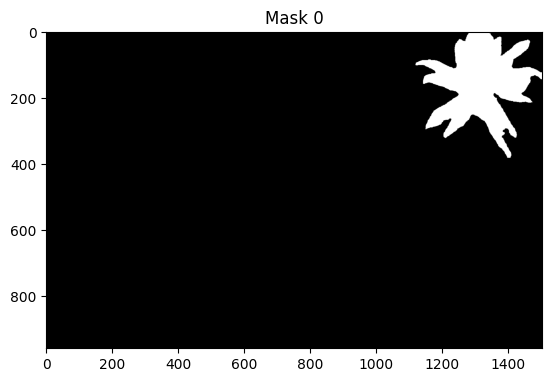

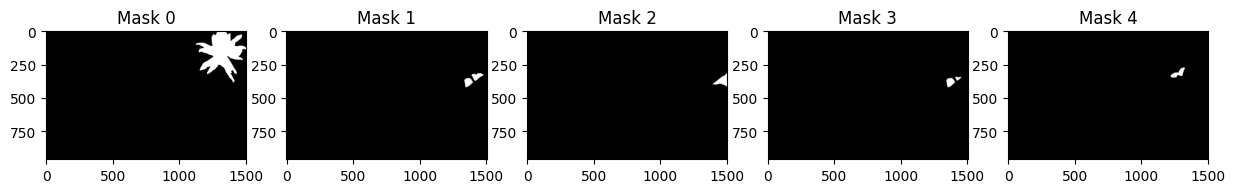

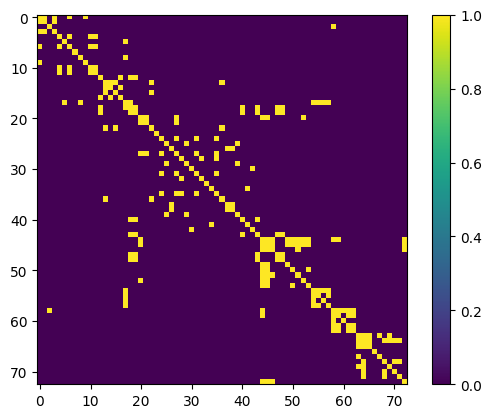

In [ ]:
# the row  i corresponds to the neighbors of the i-th sub-object
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.0)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

neighbors_matrix = np.zeros((len(mini_images_clean), len(mini_images_clean)))

# Extend the mask by n_pixels for each side to get the neighbors easily
def mask_bigger(mask, factor=1.2):
    """
    Enlarges the mask by a given factor using bilinear interpolation.
    
    Parameters:
    - mask: 2D array-like or NumPy array, representing the binary mask.
    - factor: float, scaling factor for resizing the mask.
    
    Returns:
    - A NumPy array representing the resized mask.
    """
    mask_tensor= mask["segmentation"].astype(np.uint8)
    mask_tensor = cv2.resize(mask_tensor, (0,0), fx=factor, fy=factor, interpolation=cv2.INTER_LINEAR)
    return mask_tensor


    


# Get the neighbors masks of the mask (share at least one pixel with the mask) return tensor of the neighbors
def get_neighbors_for_all_masks(masks,prior_neighbors=True):
    # Set tensor of the neighbors of the masks
    neighbors =  np.zeros((len(masks), len(masks)))
    bigger_masks = []

    for mask in masks:
        bigger_masks.append(mask_bigger(mask))

    for i in range(len(bigger_masks)):
        for j in range(i, len(bigger_masks)):
            # check if the masks share at least one pixel
            if np.sum(bigger_masks[i] * bigger_masks[j]) > 0:
                neighbors[i, j] = 1
                neighbors[j, i] = 1
    if prior_neighbors:
        # plot example of the neighbors  for one mask
        mask_example = bigger_masks[0]
        number_of_neighbors = int(np.sum(neighbors[0]))
        #plot the mask
        plt.imshow(mask_example, cmap='gray')
        plt.title(f"Mask 0")
        plt.show()
        # plot the neighbors of the mask as grid
        fig, ax = plt.subplots(1, number_of_neighbors, figsize=(15, 5))
        for i in range(number_of_neighbors):
            ax[i].imshow(bigger_masks[i], cmap='gray')
            ax[i].set_title(f"Mask {i}")
        plt.show()

        # plot the neighbors matrix
        plt.imshow(neighbors)
        plt.colorbar()
        plt.show()


    return neighbors


# Get tensor  the neighbors of the neighbors of the mask until depth layer_depth 
# Adde to the right cell in the matrix power_wight^depth
def add_neighbors_of_neighbors(neighbors_matrix,layer_depth=3, power_wight=1/2):
    for depth in  range(1,layer_depth):
        # neighbors_matrix = neighbors_matrix + neighbors_matrix@neighbors_matrix * (power_wight^depth) * size_factor
        #size_factor = size_current_mask^2/(size_neighbor^2*number_of_nighbor) (size is the number of pixels in the mask)
        neighbors_matrix = neighbors_matrix + neighbors_matrix@neighbors_matrix * (power_wight**depth) 
        # normalize the matrix
        neighbors_matrix = neighbors_matrix / np.max(neighbors_matrix)

    return neighbors_matrix


def get_neighbors_matrix(masks, layer_depth=3, power_wight=1/2):
    neighbors_matrix = get_neighbors_for_all_masks(masks)
    neighbors_matrix = add_neighbors_of_neighbors(neighbors_matrix,layer_depth=layer_depth, power_wight=power_wight)
    return neighbors_matrix


neighbors_matrix = get_neighbors_matrix(masks, layer_depth=2, power_wight=1/2)









Number of mini objects:  110


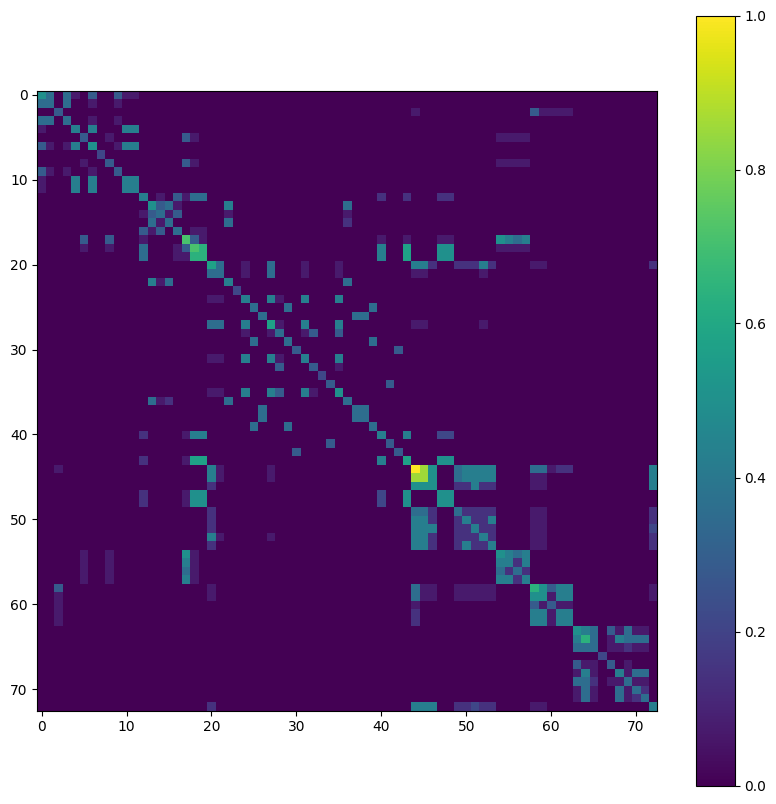

In [ ]:
# Plot hitmap of the matrix N*N where N is the number of masks(mini objects)
# 

# print number of mini objects
print("Number of mini objects: ", len(mini_images_original))
# Blue is low value and red is high value
def plot_heatmap(matrix, mini_images_original):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    im = ax.imshow(matrix)
    plt.colorbar(im)
    plt.show()

plot_heatmap(neighbors_matrix, mini_images_original)


### Score function:

We will run it only on 100 images becuse that should be enough to evaluate the algorithms, there is not havy meaning to the special ocassion due to the positional encoding  that will come later on.

First lets set up definitions:
- mask label: each mask related to a segemented sub-object in the image and group of sub-objects  are related to  some parent object in the image, the the mask label is the label of the parent object.
- label_range: The range within the sequence of masks that start in the first mini image of the mask label and end in the last mini image of the mask label.
- label_score: The number of the mini images in the label_range that contains  a different mask label, so higher label_score means that the masks are less likely to be sorted correctly.
- score: The sum of label_score for all mask labels, so higher score means that the  sorting algorithm is less likely to be correct.

The score function will be:
- score = sum(label_score for all mask labels)

### Evaluation:
- The function algorithm_evaluation(algorithm, images_with_labels,masks) will evaluate the algorithm using the images_with_labels dataset, and return the score of the algorithm.
    * for each image in the dataset, we will evaluate the algorithm using the image masks and the expected labels:
        * for each labeled object in the image, we set the all the masks from segment everything that within the labeled object mask to have the same label.
        * run the algorithm on the masks and get the score.
    * return the average score of the algorithm on the dataset.


Data set: https://www.cityscapes-dataset.com/dataset-overview/





fr

# Part 2

### Tokenaze the masks sequence of sub-objects 

From part 1 we have Boxes image sequence:
- pre-process the sequence of the sub-objects masks to boxes(mini-images)

0. Run Mae 

1. Boxes sequence to tokens sequence: pass the sequence of the boxes into the Autocoder mae

2. Tokens sequence to sequence of boxes: pass the sequence of the tokens to the model that convert the tokens to boxes (Decoder)

3. Loss function: the loss function should be:
 - Difference between the original sub-objects pixels before and after the tokenaze and de-tokenaze process(the L2 only of the pixels that are in the mask for letting the model to learn the mask environment also)

 - Classification loss of the object label

 - The correlation between the maskes of the samed object in different images (pixel wise correlation)


4. Train the model on the set of the sub-objects masks sequences

5.  Hard training: for each sub-object mask sequence, we will take the first 80% of the sequence and train the model on it, then we will take the rest 20% of the sequence and pass it to the model to predict the next 20% of the sequence, then we will take the first 80% of the sequence and the predicted 20% of the sequence and train the model on it, and so on, until the model predict the whole sequence.




## Lets load  Mae model and run example:

In [ ]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)



    # run MAE
    loss, y, mask ,tokens = model(x.float(), mask_ratio=0.0)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()
    # Return the reconstruction image
    return  y[0],tokens



In [ ]:
"""
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    sys.path.append('..')
from mae import models_mae

# This is an MAE model trained with an extra GAN loss for more realistic generation (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large_ganloss.pth

chkpt_dir = 'mae_visualize_vit_large_ganloss.pth'
model_mae_gan = prepare_model('mae_visualize_vit_large_ganloss.pth', 'mae_vit_large_patch16')
print('Model loaded.')
"""

"\nimport sys\nimport os\nimport requests\n\nimport torch\nimport numpy as np\n\nimport matplotlib.pyplot as plt\nfrom PIL import Image\n\n# check whether run in Colab\nif 'google.colab' in sys.modules:\n    print('Running in Colab.')\n    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab\n    !git clone https://github.com/facebookresearch/mae.git\n    sys.path.append('./mae')\nelse:\n    sys.path.append('..')\nfrom mae import models_mae\n\n# This is an MAE model trained with an extra GAN loss for more realistic generation (ViT-Large, training mask ratio=0.75)\n\n# download checkpoint if not exist\n!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large_ganloss.pth\n\nchkpt_dir = 'mae_visualize_vit_large_ganloss.pth'\nmodel_mae_gan = prepare_model('mae_visualize_vit_large_ganloss.pth', 'mae_vit_large_patch16')\nprint('Model loaded.')\n"

Grid size: 16x16
Mini image size: 40x40
Final image size: 640x640
The Length of the mini images:  1320
The Length of the mini images:  1320


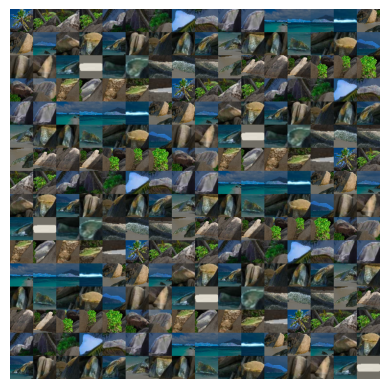

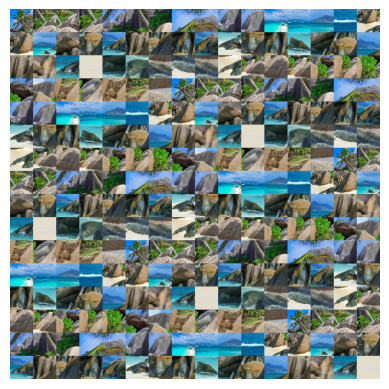

UnboundLocalError: cannot access local variable 'cropped_mask' where it is not associated with a value

In [ ]:


import numpy as np
from math import ceil, sqrt


def create_square_grid_image(mini_images,print_en=False):
    #double the mini images to be able to fill the grid, mini_images_Double = mini_images + mini_images
    mini_images_runner = []

    # Calculate the dimensions of the grid
    l = len(mini_images)
    n = 16 # The size of the grid (n x n)
    
    if l == 0:
        return None  # Return None if the list of images is empty

    # Clean the mini images that have the wrong shape
    mini_images_clean = [mini_images[i] for i in range(l) if mini_images[i].shape[0] == mini_images[i].shape[1]]
    mini_images = mini_images_clean

    channels = mini_images_clean[0].shape[2] if len(mini_images_clean[0].shape) == 3 else 1
    mini_image_size = mini_images_clean[0].shape[0]

    # Create an empty image for the final image the image is n*mini_image_size x n*mini_image_size
    img = np.zeros((n * mini_image_size, n * mini_image_size, channels), dtype=np.uint8)

    if print_en:
        # Print the grid
        print(f"Grid size: {n}x{n}")
        print(f"Mini image size: {mini_image_size}x{mini_image_size}")
        print(f"Final image size: {n * mini_image_size}x{n * mini_image_size}")

    # Fill the grid
    # Make  set of mini images twice
    mini_image_runner = []
    for i in range(2):
        mini_image_runner += mini_images_clean + mini_images_clean  + mini_images_clean + mini_images_clean
    mini_images_clean = mini_image_runner + mini_images_clean + mini_images_clean  + mini_images_clean + mini_images_clean

    for i in range(n):
        for j in range(n):
            idx = i * n + j
            # Check if the mini image have the same shape as the mini_image_size
            if mini_images_clean[idx].shape[0] != mini_image_size or mini_images_clean[idx].shape[1] != mini_image_size:
                print(f"Mini image {idx} has the wrong shape")
            else:
                img[i * mini_image_size:(i + 1) * mini_image_size, j * mini_image_size:(j + 1) * mini_image_size] = mini_images_clean[idx]

    print("The Length of the mini images: ", len(mini_images_clean))
    return img



# the size of mini images is the image devide by the grid_n
def getmini_images_squares(image, masks, grid_n=16):
    # Get the mini images
    mini_images_squares = [] #white outside the mask
    for mask in masks:
        # Get the bounding box of the mask
        x, y, w, h = cv2.boundingRect(mask["segmentation"].astype(np.uint8))
        # Get the square image of the mask
        mini_image = image[y:y+h, x:x+w]
        # Out of the segment is white in the mini image squere, adjust the mask to the mini image
        mask = mask["segmentation"].astype(np.uint8)# this mask is the same as the mask in the masks
        mask = mask[y:y+h, x:x+w] 
        # Create a white image
        white = np.ones_like(mini_image) * 255
        # Mni image filter *0.2 outside the mask
        mini_image = np.where(mask[..., None] == 0, 0.5 * mini_image, mini_image)
        # First, ensure the mask is boolean for proper broadcasting
        cropped_mask = cropped_mask.astype(bool)

        # Convert the mask to 3 channels to work with a color image
        mask_3ch = np.stack([cropped_mask] * 3, axis=-1)

        # Modify only the pixels outside the mask to 20% of their original value
        processed_image = np.where(mask_3ch, image, 0.2 * image)
        mini_image = processed_image

        
        mini_images_squares.append(mini_image)



        

        # Resize the mini image to the grid size
        mini_image = cv2.resize(mini_image, (grid_n, grid_n))
        mini_images_squares.append(mini_image)
      

    return mini_images_squares






img = create_square_grid_image(mini_images_clean,print_en=True)
img_in = create_square_grid_image(mini_images_original)


            

# Check if img is not None and is an instance of a numpy array
if img is not None and isinstance(img, np.ndarray):
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    plt.imshow(img_in)
    plt.axis('off')
    plt.show()




# If not saved , save the image in file
if not os.path.exists('grid_image.jpg'):
    cv2.imwrite('grid_image.jpg', cv2.cvtColor(img * 255, cv2.COLOR_RGB2BGR))





"""
# Setof images to run
img_out,tokens = run_one_image(img_out, model_mae_gan)
plt.imshow(img_out)
plt.axis('off')
plt.show()

# print the tokens
for token in tokens :
    print (token  )

# Tokens damenstions
print("Tokens damenstions: ", tokens.shape)
"""

#get miniimagw squares
mini_images_squares = getmini_images_squares(image, masks, grid_n=16)



In [ ]:



def print_grid(images, n_cols=16):
    # Check if the list of images is not empty
    if len(images) == 0:
        print("The list of images is empty")
        return

    # create a square grid of images
    n_rows = n_cols
    img = np.zeros((n_rows * images[0].shape[0], n_cols * images[0].shape[1], images[0].shape[2]), dtype=np.uint8)
    #  for adjust to the size multiple the the images as needed like 1 2 3 1 2 3 1 2 3 
    index_image=0
    for i in range(n_cols):
        for i in range(n_cols):
            if i < len(images):
                img[i * images[0].shape[0]:(i + 1) * images[0].shape[0], j * images[0].shape[1]:(j + 1) * images[0].shape[1]] = images[index_image]
                index_image += 1
            else:
                index_image = 0
    plt.imshow(img)





# Add conv masck for position encoding and shape encoding

In [ ]:



masks = image2Vec.image2segVec(image=image,size=(256,256))
# Get the mini images
mini_images_clean, mini_images_original= image2Vec.create_mini_images(image, masks,size=(40,40))
mini_images_clean = getmini_images_squares(image, masks, grid_n=16)


# Example of mini image + conv mask
mini_img = mini_images_clean[30]
plt.imshow(mini_img)



mask = masks[30]
#print img  binary mask (0,1) beside the mini image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(mini_img)
ax[0].set_title("Mini image")
ax[1].imshow(mask["segmentation"], cmap='gray')
ax[1].set_title("Binary mask")
plt.show()




UnboundLocalError: cannot access local variable 'cropped_mask' where it is not associated with a value

In [ ]:

"""
# conv on the mask binary image and add it to the mini image of the corresponding mask
def image2VecWithMaskConv(image,plot_img=False, plot_grid_mini_img=False,plot_mask_plus_mini_img=False):
    masks = image2Vec.image2segVec(image=image,size=(256,256))

    if plot_img:
        data_utils.show_image_and_mask(image, masks)

    mini_images_clean = getmini_images_squares(image, masks, grid_n=16)

    if plot_grid_mini_img:
        image2Vec.print_grid(mini_images_clean,n_cols=16)

    for i in range(len(mini_images_clean)):
        mini_img = mini_images_clean[i]
        mask = masks[i]
        # Create a binary mask
        mask = mask["segmentation"]
        # Convert the mask to a 3-channel image
        mask = np.stack([mask, mask, mask], axis=-1)
        
        # Apply a convolutional over the mask binry into information as patch of th image shape(note)
        mask_conv= cv2.filter2D(mask, -1, np.ones((3, 3), np.float32) / 9)
        # Add the mask to the mini image
        mini_images_clean[i] = np.concatenate([mini_img, mask_conv], axis=1)

        


    if plot_mask_plus_mini_img:
        image2Vec.print_grid(mini_images_clean,n_cols=16)
    return mini_images_clean

# plot image, image gride clean
mini_images_clean = image2VecWithMaskConv(image,plot_img=True, plot_grid_mini_img=True,plot_mask_plus_mini_img=True)
"""

'\n# conv on the mask binary image and add it to the mini image of the corresponding mask\ndef image2VecWithMaskConv(image,plot_img=False, plot_grid_mini_img=False,plot_mask_plus_mini_img=False):\n    masks = image2Vec.image2segVec(image=image,size=(256,256))\n\n    if plot_img:\n        data_utils.show_image_and_mask(image, masks)\n\n    mini_images_clean = getmini_images_squares(image, masks, grid_n=16)\n\n    if plot_grid_mini_img:\n        image2Vec.print_grid(mini_images_clean,n_cols=16)\n\n    for i in range(len(mini_images_clean)):\n        mini_img = mini_images_clean[i]\n        mask = masks[i]\n        # Create a binary mask\n        mask = mask["segmentation"]\n        # Convert the mask to a 3-channel image\n        mask = np.stack([mask, mask, mask], axis=-1)\n        \n        # Apply a convolutional over the mask binry into information as patch of th image shape(note)\n        mask_conv= cv2.filter2D(mask, -1, np.ones((3, 3), np.float32) / 9)\n        # Add the mask to t

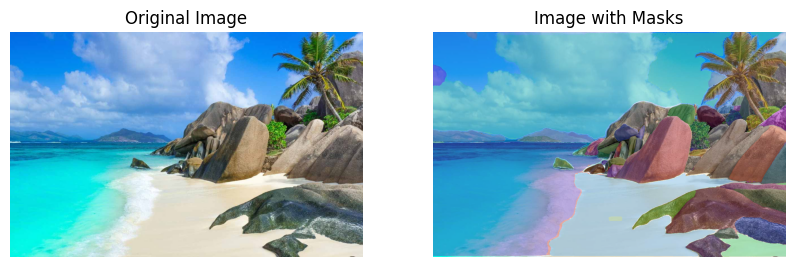

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..254.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB dat

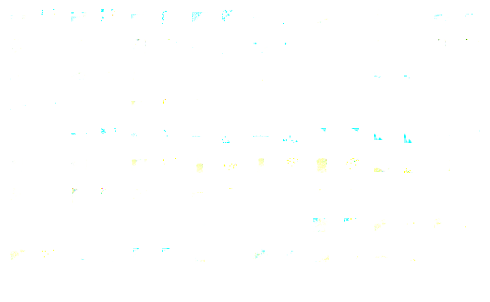

NameError: name 'nn' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def apply_conv_to_mask(mask, patch_size=16):
    # Convert mask to a tensor
    mask_tensor = torch.tensor(mask, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    # Define a convolutional layer
    conv_layer = nn.Conv2d(1, 1, kernel_size=patch_size, stride=patch_size, padding=0, bias=False)
    conv_layer.weight.data.fill_(1.0 / (patch_size * patch_size))  # Averaging filter

    # Apply convolution
    with torch.no_grad():
        result = conv_layer(mask_tensor)

    return result.squeeze().numpy()

def image2VecWithMaskConv(image, plot_img=False, plot_grid_mini_img=False, plot_mask_plus_mini_img=False):
    masks = image2Vec.image2segVec(image=image, size=(256, 256))

    if plot_img:
        data_utils.show_image_and_mask(image, masks)

    mini_images_clean = getmini_images_squares(image, masks, grid_n=16)

    if plot_grid_mini_img:
        image2Vec.print_grid(mini_images_clean, n_cols=16)
        


    combined_images = []
    for i in range(len(mini_images_clean)):
        mini_img = mini_images_clean[i]
        mask = masks[i]["segmentation"]
        
        # Convert the mask to a 3-channel image
        mask = np.stack([mask, mask, mask], axis=-1)
        
        # Apply convolution to the mask
        mask_conv = apply_conv_to_mask(mask[:, :, 0], patch_size=16)  # Apply to one channel, results are the same for all
        
        # Resize the convolution result to match the mini image size
        conv_resized = cv2.resize(mask_conv, (mini_img.shape[1], mini_img.shape[0]))
        
        # Scale convolution results to make less aggressive changes
        conv_scaled = conv_resized * 0.5 * 255  # Adjust the scale factor as needed

        # Combine the mini image with scaled convolution features and clip to avoid overflow
        mini_img_with_features = np.clip(mini_img + conv_scaled, 0, 255)

        combined_images.append(mini_img_with_features.astype(np.uint8))
        
    if plot_mask_plus_mini_img:
        image2Vec.print_grid(combined_images, n_cols=16)
           
    return combined_images

# Plot the image, grid of mini images, and grid of mini images with mask convolution
mini_images_clean = image2VecWithMaskConv(image, plot_img=True, plot_grid_mini_img=True, plot_mask_plus_mini_img=True)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def apply_fourier_transform(mask):
    # Assume mask is single-channel
    fft_mask = np.fft.fft2(mask)
    fft_shift = np.fft.fftshift(fft_mask)  # Shift the zero frequency component to the center
    return fft_shift

def apply_inverse_fourier_transform(fft_shift):
    ifft_shift = np.fft.ifftshift(fft_shift)  # Shift back (inverse shift)
    ifft_mask = np.fft.ifft2(ifft_shift)
    mask_real = np.real(ifft_mask)  # Get the real part
    return mask_real

def process_image_patches(image, masks, num_col_patches):
    mini_images = getmini_images_squares(image, masks, grid_n=num_col_patches)
    combined_images = []

    for mini_img, mask in zip(mini_images, masks):
        fft_mask = apply_fourier_transform(mask)
        mask_real = apply_inverse_fourier_transform(fft_mask)
        mask_scaled = cv2.resize(mask_real, (mini_img.shape[1], mini_img.shape[0]), interpolation=cv2.INTER_LINEAR)
        mask_scaled = cv2.normalize(mask_scaled, None, 0, 255, cv2.NORM_MINMAX)  # Normalize to [0, 255]

        mini_img_with_features = np.clip(mini_img + mask_scaled[:, :, None], 0, 255).astype(np.uint8)
        combined_images.append(mini_img_with_features)

    return combined_images

def plot_images(images):
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(images, 1):
        plt.subplot(4, 4, i)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.show()


# Processing and displaying
processed_images = process_image_patches(image, masks, num_col_patches=16)
plot_images(processed_images)


TypeError: 'NoneType' object is not subscriptable

In [ ]:
from transformers import BeitFeatureExtractor, BeitForSemanticSegmentation
from PIL import Image

# Load ADE20K image dataset

# Initialize the feature extractor and model
feature_extractor = BeitFeatureExtractor.from_pretrained('microsoft/beit-large-finetuned-ade-640-640')
model = BeitForSemanticSegmentation.from_pretrained('microsoft/beit-large-finetuned-ade-640-640')

# Load an image grid 
image = Image.open('grid_image.jpg')

# Prepare the image for the model
inputs = feature_extractor(images=image, return_tensors="pt")

# Forward pass to get logits
outputs = model(**inputs)
logits = outputs.logits  # logits are of shape (batch_size, num_labels, height/4, width/4)





2024-06-18 23:11:33.924809: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-18 23:11:33.972610: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-06-18 23:11:35.619345: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/benjaminc/project_transformers/satenv/lib/python3.12/site-packages/transformers/models/beit/feature_extraction_beit.py:28: FutureWarning: The class BeitFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use BeitImageProcessor instead.
  warnings.warn(
--- Logging error ---
Traceback (most recent call last):
  File "/home/benjaminc/miniconda3/lib/python3.12/logging/__init__.py", line 1160, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "/home/benjaminc/miniconda3/lib/python3.12/logging/__init__.py", line 999, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "/home/benjaminc/miniconda3/lib/python3.12/logging/__init__.py", line 703, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "/home/benjaminc/miniconda3/lib/python3.

In [ ]:
def img2gridImage(img,original_img=True):
    masks = image2Vec.image2segVec(image=img,size=(256,256))
    mini_images_clean, mini_images_original= image2Vec.create_mini_images(img, masks,size=(40,40))
    #img = create_square_grid_image(mini_images_clean,print_en=True)
    img_in = create_square_grid_image(mini_images_original)
    if original_img:
        return img_in
    else:
     return img


img_to_print = img2gridImage(image)

plt.imshow(img_to_print)



AttributeError: 'JpegImageFile' object has no attribute 'shape'

### Image Tokenizer Class


In [ ]:
import torch
import torch.nn.functional as F
import math

list_of_locations = []
# Center of the mask i is considered as the location of the mask mini_images_clean[i]
for mask in masks:
    list_of_locations.append(mask["bbox"])





class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000, tokens=tokens, list_of_locations=list_of_locations):
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
      

        # Compute the positional encoding for each token
        for i in range(len(tokens)):
            # fit for the mask i
            # Positional encoding for the mask i
            x = list_of_locations[i][0]
            y = list_of_locations[i][1]
            w = list_of_locations[i][2]
            h = list_of_locations[i][3]

            # Center of the mask i
            x_center = x + w // 2
            y_center = y + h // 2
            # Positional encoding for the center of the mask i
            

        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        return tokens
    

        

# Print the tokens after applying the positional encoding
for token in tokens:
    print(token)



           
                


NameError: name 'nn' is not defined

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)
    

class SemanticEncoder(nn.Module):
    def __init__(self, d_model, nhead, num_encoder_layers, num_classes):
        super(SemanticEncoder, self).__init__()
        self.positional_encoding = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=512, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.decoder = nn.Linear(d_model, num_classes)

    def forward(self, src, src_positions):
        src = self.positional_encoding(src)  # Assuming src is already batch first
        output = self.transformer_encoder(src)
        logits = self.decoder(output.mean(dim=1))
        return logits

class TransformerModel(nn.Module):
    def __init__(self, d_model, nhead, num_encoder_layers, num_classes):
        super(TransformerModel, self).__init__()
        self.semantic_encoder = SemanticEncoder(d_model, nhead, num_encoder_layers, num_classes)

    def forward(self, src, src_positions=None):
        logits = self.semantic_encoder(src, src_positions)
        return logits

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
d_model = 512
nhead = 8
num_encoder_layers = 6
num_classes = 10

model = TransformerModel(d_model, nhead, num_encoder_layers, num_classes).to(device)

# Example usage
# Assuming src and src_positions are defined and properly shaped
# logits = model(src, src_positions)

# Run example
tokensrun = tokens
tokensrun = tokensrun.to(device)
src_positions = torch.tensor(list_of_locations).to(device)
logits = model(tokensrun, src_positions)
print(logits)

class TransformerBlock(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, activation='relu'):
        super(TransformerBlock, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, src):
        src2 = self.self_attn(src, src, src)[0]
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

class GPTVisionMaskToClass(nn.Module):
    def __init__(self, d_model, nhead, num_encoder_layers, num_classes):
        super(GPTVisionMaskToClass, self).__init__()
        self.positional_encoding = PositionalEncoding(d_model)
        self.transformer_blocks = nn.ModuleList([TransformerBlock(d_model, nhead) for _ in range(num_encoder_layers)])
        self.decoder = nn.Linear(d_model, num_classes)

    def forward(self, src):
        src = self.positional_encoding(src)  # Assuming src is already batch first
        for transformer_block in self.transformer_blocks:
            src = transformer_block(src)
        logits = self.decoder(src.mean(dim=1))
        return logits
    


    
# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
d_model = 512
nhead = 8
num_encoder_layers = 6
num_classes = 10

model = GPTVisionMaskToClass(d_model, nhead, num_encoder_layers, num_classes).to(device)

# Example usage
# Assuming src is defined and properly shaped

tokensrun = tokens
tokensrun = tokensrun.to(device)
src_positions = torch.tensor(list_of_locations).to(device)
logits = model(tokensrun)


best_class = logits.argmax(dim=1)
print(best_class)



/home/benjaminc/project_transformers/satenv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


RuntimeError: CUDA error: device kernel image is invalid
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


### 2.1 Boxes sequence to tokens sequence with mae model

# Part 3 Multi Head Attention (Amit)

### 1 Label attention between the sub-objects in the image

1. The Encoder should return the tokens sequence and the labels of the tokens in terms k means clustering of the tokens:
number of objects = N
number of tokens = K

- input : tokens sequence
 

- output : tokens sequence +  N X N matrix of labels of the tokens, the place i j is the probability of the sub-object i to be in the same object of the sub-object j


Note: This neccesary for the model to learn the semantic layers of the image, or in another words what belong to the same object and , the distance the sub-objects in the image, understanding how to score if two sub-objects are the same object or not in terms of semantic make-sense and texture information.




### Attention model:
- MASKED IMAGE MODELING AS KNOWLEDGE DISTILLATION https://export.arxiv.org/pdf/2111.07832 

### benchmarks:
- Source: CAST: CONCURRENT RECOGNITION AND
SEGMENTATION WITH ADAPTIVE SEGMENT TOKENS https://arxiv.org/pdf/2210.00314.pdf 


1. **ImageNet (IN-1k)**: Evaluates unsupervised image classification, using top-1 accuracy as a metric. [ImageNet](http://www.image-net.org/)
   
2. **ImageNet (IN-100)**: A subset of ImageNet for more focused classification tasks, assessing model performance and efficiency. [ImageNet Subset (Refer to the main ImageNet link)](http://www.image-net.org/)

3. **Pascal VOC 2012 (Semantic Segmentation)**: Measures object-centric semantic segmentation capabilities with mIoU and boundary F-score metrics. [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/)

4. **MSCOCO (Scene Parsing)**: Tests on generic scene parsing to evaluate complex scene understanding and segmentation efficiency. [MSCOCO](https://cocodataset.org/#home)

5. **ImageNet Classification on IN-100 with ViT-S and ViT-B backbones**: Compares model efficiency and task performance in image classification on the IN-100 subset. [ImageNet](http://www.image-net.org/)

6. **Semantic Segmentation on VOC with Model Efficiency Comparison**: Focuses on unsupervised semantic segmentation efficiency and accuracy on the Pascal VOC dataset. [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/)

7. **Figure-Ground Segmentation on VOC (Jaccard Similarity)**: Evaluates the precision of latent attention in segmenting foreground objects by comparing to ground truths using Jaccard similarity. [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/)






1. **Datasets**: The evaluation leverages widely recognized datasets, each serving specific purposes:
   - **ImageNet (IN-1k and IN-100)** for unsupervised image classification to gauge model accuracy and efficiency.
   - **Pascal VOC 2012** for object-centric semantic segmentation, focusing on model precision in segmenting specific object categories.
   - **MSCOCO** for generic scene parsing, assessing the model's ability to understand complex scene contexts.

2. **Model Architecture**: The architecture is based on a modified Vision Transformer (ViT), with adaptations such as:
   - Replacement of the patch-wise linear projection layer with convolutional layers.
   - Adjustment in the number of encoder blocks to maintain model capacity.
   - Stride settings among convolutional layers to aggregate pixel features within superpixels.

3. **Clustering and Token Pooling**: K-Medoids clustering complements the model by subsampling tokens based on significance, comparing with Token Pooling and assessing efficiency and segmentation accuracy.

4. **Image Resolution and Token Numbers**: Varies depending on the dataset and task:
   - For ImageNet training and testing, a standard crop size is used with a partition into superpixels, aligning the number of input tokens with traditional ViT inputs.
   - For Pascal VOC, superpixels are generated based on a higher resolution input image to accommodate semantic and figure-ground segmentation.

5. **Training Setup**: Training from scratch without human-labeled supervision, leveraging the MoCo framework with specific configurations:
   - Batch size, learning rate, weight decay, and momentum settings tailored for each dataset.
   - Use of the AdamW optimizer and setting specific hyperparameters for the MoCo framework.

6. **Evaluation Metrics**: Performance is evaluated using metrics suited to each task, such as top-1 accuracy for image classification and mIoU along with F-score for segmentation tasks.

7. **Comparative Analysis**: The model's performance is directly compared against several baselines, including different versions of ViT and approaches employing token pooling, focusing on the trade-off between model efficiency and task performance.

This setup provides a comprehensive framework for evaluating the model's capabilities in handling both classification and segmentation tasks, emphasizing unsupervised learning scenarios without reliance on labeled data.


### Evaluation plan:


### 1. Dataset Preparation and Preprocessing
- **ImageNet (IN-1k and IN-100)**: Utilize both the full ImageNet dataset and the IN-100 subset for image classification tasks. Ensure you follow the same protocol for creating the IN-100 subset.
- **Pascal VOC 2012**: Employ this dataset for semantic segmentation, using the augmented training and validation sets as specified.
- **MSCOCO**: Use for scene parsing, training on the specified split, and testing on the VOC validation set to assess segmentation capabilities in more complex scenes.

### 2. Model Architecture Adaptations
- Adapt your model architecture based on ViT-S or a similar transformer model. Integrate key modifications that align with their approach, such as adjusting the number of encoder blocks or replacing certain layers to better handle the segmentation and tokenization of image segments.

### 3. Training and Evaluation Strategy
- Train models from scratch without labeled supervision, leveraging an unsupervised learning framework like MoCo for learning representations.
- For ImageNet, evaluate using linear probing to assess unsupervised classification performance.
- On Pascal VOC, evaluate semantic segmentation using nearest neighbor search from a labeled training set, and explore the effectiveness of fine-tuning on segmentation tasks.
- Implement a method to assess figure-ground segmentation on VOC, possibly through attention maps or another innovative approach to foreground-background separation.

### 4. Key Metrics for Comparison
- Focus on top-1 accuracy for ImageNet classification tasks to measure model efficiency and accuracy.
- Use mean Intersection over Union (mIoU) and boundary F-score for semantic segmentation on Pascal VOC to evaluate the precision of segmentation.
- For scene parsing on MSCOCO, consider using similar metrics tailored to the complexity of scene contexts.
- Benchmark hierarchical segmentation abilities, especially if your model also targets multi-scale segmentations.

### 5. Novelty in Your Approach
- Highlight unique aspects of your model, especially if it introduces new methods for tokenizing image segments or achieves a more efficient way to handle image-to-segment transformations.
- Demonstrate any improvements in computational efficiency, segmentation accuracy, or the ability to capture fine-grained details within images.

### 6. Documenting Your Findings
- Ensure to document your methodology clearly, including dataset preparation, model architecture details, training protocols, and evaluation metrics.
- Compare your results directly with the benchmarks set by the paper, highlighting areas where your model outperforms or offers significant advantages.

### 7. Additional Considerations
- If applicable, consider exploring extensions or improvements in areas not fully addressed by their model, such as scalability to larger datasets, adaptability to different domains, or improvements in unsupervised learning techniques.
